# Cummings et al. 2017 - GTEx v6 RPKM

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
import sys
from pathlib import Path
import seaborn as sns

In [3]:
sys.path.append(str(Path.home() / 'Code/sctoolkit'))

In [4]:
from sctoolkit.utils import sort_by_correlation, bin_pval

In [5]:
sc.set_figure_params(dpi=100)

In [6]:
from qtl.norm import deseq2_normalized_counts

In [7]:
coding_genes = sc.read('adata.h5ad').var_names.tolist()

## Read Cummings et al. patient data in RPKM

In [8]:
mu = pd.read_table('remapped_patient.rpkm.080217.txt').T

var = mu.iloc[:2].T
var.set_index('Description', inplace=True)
var.index.name = None

mu = mu.iloc[2:].astype(float)

mu.columns = var.index.values

In [9]:
var.head()

,Name
TSPAN6,ENSG00000000003.10
TNMD,ENSG00000000005.5
DPM1,ENSG00000000419.8
SCYL3,ENSG00000000457.9
C1orf112,ENSG00000000460.12


In [10]:
metadata = pd.read_excel('Cummings_etal_Table S1.xlsx', skiprows=1, index_col=0)
metadata.head()

,Clinical Diagnosis,Sex,Age at muscle biopsy,Site of biopsy,Previous NGS testing,Status of genetic diagnosis before RNA-seq,Notes on genetic diagnosis status
Patient ID,,,,,,,
D1,Congenital muscular dystrophy,M,1y,Quadriceps,"WES, array CGH",Diagnosed,NaN
D2,Congenital muscular dystrophy,M,12y,Quadriceps/Triceps,WES,Diagnosed,NaN
C1,Congenital muscular dystrophy,M,5y,Quadriceps,WGS,Strong candidate gene,One pathogenic essential splice site variant i...
N1,Congenital muscular dystrophy,F,10y,Gluteal,"WES, WGS",No strong candidates,NaN
N2,Congenital muscular dystrophy,M,43y,L medial gastroc,"WES, WGS",No strong candidates,NaN


In [11]:
merged = metadata.join(mu, how='inner')

obs = merged.iloc[:, :metadata.shape[1]]
obs['patient_id'] = obs.index.astype(str).copy()
for c in obs.columns:
    obs[c] = obs[c].str.strip().str.replace('Limb girdle', 'Limb-girdle').str.replace('Complex skeletal myopathy, with CNS and smooth muscle abnormalities', 'Complex skeletal myopathy')

X = merged.iloc[:, metadata.shape[1]:]

In [12]:
obs.head()

,Clinical Diagnosis,Sex,Age at muscle biopsy,Site of biopsy,Previous NGS testing,Status of genetic diagnosis before RNA-seq,Notes on genetic diagnosis status,patient_id
D1,Congenital muscular dystrophy,M,1y,Quadriceps,"WES, array CGH",Diagnosed,NaN,D1
D2,Congenital muscular dystrophy,M,12y,Quadriceps/Triceps,WES,Diagnosed,NaN,D2
C1,Congenital muscular dystrophy,M,5y,Quadriceps,WGS,Strong candidate gene,One pathogenic essential splice site variant i...,C1
N3,Congenital muscular dystrophy,M,3y,Quadriceps,WGS,No strong candidates,NaN,N3
D3,Limb-girdle muscular dystrophy,F,52y,Quadriceps,"Gene panel,WES, WGS",Diagnosed,NaN,D3


In [13]:
X.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RP11-309M23.1,AMDP1,BX649553.1,BX649553.2,BX649553.3,BX649553.4,RN7SL355P,MIR3690,AL732314.1,AJ271736.10
D1,2.493582,1.024688,15.452623,1.412168,0.195411,2.024854,22.228598,7.272854,1.520344,3.078175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D2,1.896236,49.448524,32.142845,1.513735,0.078695,0.218691,22.929836,3.705019,1.598425,1.233825,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1,2.423616,2.957252,20.918526,1.971403,0.139721,0.872147,21.052916,5.180873,1.728183,1.877674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N3,11.059342,5.583167,22.397917,3.526784,0.709406,2.756086,34.770771,10.545596,5.354416,5.882776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D3,2.024290,0.474373,18.842169,2.296871,0.226392,1.265329,19.033346,2.905757,2.218423,2.935546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
obs['Clinical Diagnosis'].value_counts()

Congenital myopathy                     7
Nemaline myopathy                       7
Limb-girdle muscular dystrophy          6
Congenital muscular dystrophy           4
Duchenne muscular dystrophy             4
Myopathy                                3
Collagen VI-related dystrophy           3
Centronuclear myopathy                  2
Emery-Dreifuss muscular dystrophy       1
Merosin-deficient muscular dystrophy    1
Multi/minicore congenital myopathy      1
Ehler's Danlos Syndrome Type VI         1
Fetal akinesia                          1
Myalgia, myoglobinuria                  1
Complex skeletal myopathy               1
Arthrogryposis                          1
Name: Clinical Diagnosis, dtype: int64

In [15]:
ad = sc.AnnData(sp.sparse.csr_matrix(X.values), obs=obs, var=var)
ad = ad[ad.obs.patient_id != 'D9'].copy()
ad.var_names_make_unique()
ad = ad[ad.obs['Clinical Diagnosis'].notnull()].copy()
ad.var_names_make_unique()
ad._sanitize()
ad.obs.patient_id = ad.obs.patient_id.astype('category')
ad

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3', 'SNORD113-4', 'SNORD113-5']
/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'Clinical Diagnosis' as categorical
/home/gokcen/.miniconda3/lib/python3.8/site-packages/anndat

AnnData object with n_obs × n_vars = 43 × 56318
    obs: 'Clinical Diagnosis', 'Sex', 'Age at muscle biopsy', 'Site of biopsy', 'Previous NGS testing', 'Status of genetic diagnosis before RNA-seq', 'Notes on genetic diagnosis status', 'patient_id'
    var: 'Name'

In [16]:
ad.layers['RPKM'] = ad.X.copy()

In [19]:
sc.pp.normalize_total(ad, target_sum=1e6)
ad.layers['TPM'] = ad.X.copy()
sc.pp.log1p(ad)
ad.layers['logTPM'] = ad.X.copy()
sc.pp.scale(ad)
sc.pp.pca(ad)
sc.pp.neighbors(ad, n_neighbors=5, metric='correlation')
sc.tl.leiden(ad, resolution=0.5)
sc.tl.umap(ad)

In [246]:
ad_logtpm = ad.copy()
ad_logtpm.X = ad_logtpm.layers['logTPM'].copy()

In [247]:
highn = ad_logtpm.obs['Clinical Diagnosis'].value_counts()>1
highn = highn[highn].index.values.astype(str)
highn

array(['Congenital myopathy', 'Nemaline myopathy',
       'Limb-girdle muscular dystrophy', 'Congenital muscular dystrophy',
       'Duchenne muscular dystrophy', 'Collagen VI-related dystrophy',
       'Myopathy'], dtype='<U36')

In [248]:
genes = coding_genes

In [249]:
ad_logtpm = ad_logtpm[ad_logtpm.obs['Clinical Diagnosis'].isin(highn), ad_logtpm.var_names[ad_logtpm.var_names.isin(genes)]].copy()
ad_logtpm

AnnData object with n_obs × n_vars = 34 × 16843
    obs: 'Clinical Diagnosis', 'Sex', 'Age at muscle biopsy', 'Site of biopsy', 'Previous NGS testing', 'Status of genetic diagnosis before RNA-seq', 'Notes on genetic diagnosis status', 'patient_id', 'leiden'
    var: 'Name', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RPKM', 'TPM', 'logTPM'
    obsp: 'distances', 'connectivities'

## Read GTEx data

In [26]:
gtex_controls = pd.read_excel('Cummings_etal_Table S4.xlsx', skiprows=2, header=None).values.squeeze()
gtex_controls[:20]

array(['G16537.GTEX-OHPL-1626.2', 'G16558.GTEX-P4PP-1626.2',
       'G16582.GTEX-OHPM-1626.3', 'G16596.GTEX-OIZH-1626.2',
       'G16598.GTEX-P4PQ-1626.2', 'G16687.GTEX-OOBJ-1626.3',
       'G18069.GTEX-OHPK-1626-SM-2YUN3.1',
       'G18373.GTEX-QCQG-2126-SM-2S1P8.1',
       'G18402.GTEX-Q2AH-1826-SM-2S1Q2.1',
       'G18404.GTEX-QDVN-2426-SM-2S1Q4.1',
       'G18447.GTEX-QV44-2026-SM-2S1RD.1',
       'G19326.GTEX-S32W-2326-SM-2XCAW.1',
       'G19355.GTEX-S7SF-2026-SM-3K2AS.1',
       'G19468.GTEX-POYW-0526-SM-2XCEY.2',
       'G19491.GTEX-SNMC-1426-SM-2XCFM.2',
       'G20855.GTEX-O5YT-1626-SM-32PK6.1',
       'G20912.GTEX-SUCS-1626-SM-32PLS.2',
       'G21042.GTEX-TML8-1826-SM-32QOR.1',
       'G21087.GTEX-TKQ2-0826-SM-33HB6.1',
       'G21092.GTEX-TMMY-0426-SM-33HBB.1'], dtype=object)

In [27]:
gtex_controls_wo_sample = [i.split('.')[1] for i in gtex_controls if '-SM-' not in i]
gtex_controls_with_sample = [i.split('.')[1] for i in gtex_controls if '-SM-' in i]

In [28]:
bulk = sc.read('gtexv6/gtex-v6-rpkm.h5ad') ## RPKM
bulk.var_names_make_unique()

bulk.obs.rename(columns={'SMTS': 'Tissue', 'SMTSD': 'Tissue detail'}, inplace=True)
bulk.obs['Sample ID'] = bulk.obs.index

bulk.obs['Clinical Diagnosis'] = 'Healthy individuals (GTEx v6)'
bulk.layers['RPKM'] = bulk.X.copy()

bulk = bulk[bulk.obs['Tissue detail'] == 'Muscle - Skeletal'].copy()

In [31]:
sc.pp.normalize_total(bulk, target_sum=1e6)
bulk.layers['TPM'] = bulk.X.copy()
sc.pp.log1p(bulk)
bulk.layers['logTPM'] = bulk.X.copy()

In [32]:
len(gtex_controls)

184

In [33]:
bulk

AnnData object with n_obs × n_vars = 430 × 56318
    obs: 'SMATSSCR', 'SMCENTER', 'SMPTHNTS', 'SMRIN', 'Tissue', 'Tissue detail', 'SMUBRID', 'SMTSISCH', 'SMTSPAX', 'SMTSTPTREF', 'SMNABTCH', 'SMNABTCHT', 'SMNABTCHD', 'SMGEBTCH', 'SMGEBTCHD', 'SMGEBTCHT', 'SMAFRZE', 'SMGTC', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT', 'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH', 'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT', 'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR', 'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF', 'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH', 'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART', 'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS', 'SUBJID', 'GENDER', 'AGE', 'DTHHRDY', 'Sample ID', 'Clinical Diagnosis'
    var: 'Name'
    uns: 'log1p'
    layers: 'RPKM', 'TPM', 'logTPM'

In [34]:
control_idx = (np.array([bulk.obs.index.str.startswith(x) for x in gtex_controls_wo_sample])).sum(0).astype(bool)
control_idx2 = bulk.obs.index.isin(gtex_controls_with_sample)

In [35]:
bulk = bulk[(control_idx | control_idx2)].copy()
sc.pp.subsample(bulk, n_obs=20)

In [36]:
sc.pp.pca(bulk)

## Concatenate

In [37]:
ad_logtpm = ad.copy()
ad_logtpm.X = ad_logtpm.layers['logTPM'].copy()

In [38]:
ad_logtpm

AnnData object with n_obs × n_vars = 43 × 56318
    obs: 'Clinical Diagnosis', 'Sex', 'Age at muscle biopsy', 'Site of biopsy', 'Previous NGS testing', 'Status of genetic diagnosis before RNA-seq', 'Notes on genetic diagnosis status', 'patient_id', 'leiden'
    var: 'Name', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'umap', 'Clinical Diagnosis_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RPKM', 'TPM', 'logTPM'
    obsp: 'distances', 'connectivities'

In [39]:
ad_logtpm.obs['Tissue detail'] = 'Patient muscle'

In [40]:
muscle = sc.concat([bulk, ad_logtpm])
muscle

AnnData object with n_obs × n_vars = 63 × 56318
    obs: 'Tissue detail', 'Clinical Diagnosis'
    obsm: 'X_pca'
    layers: 'RPKM', 'TPM', 'logTPM'

In [41]:
coding_genes = np.array(coding_genes)[np.isin(coding_genes, muscle.var_names)].tolist()
muscle = muscle[:, coding_genes].copy()

In [42]:
muscle

AnnData object with n_obs × n_vars = 63 × 16843
    obs: 'Tissue detail', 'Clinical Diagnosis'
    obsm: 'X_pca'
    layers: 'RPKM', 'TPM', 'logTPM'

In [43]:
muscle.layers['logTPM'] = muscle.X.copy()

In [44]:
muscle.layers['TPM']

<63x16843 sparse matrix of type '<class 'numpy.float32'>'
	with 979589 stored elements in Compressed Sparse Row format>

In [62]:
muscle_diseases = pd.read_feather('../../musclediseasegenes-processed.feather')
muscle_diseases = muscle_diseases[muscle_diseases.Gene.isin(muscle_list)]
muscle_diseases['Disease group'] = muscle_diseases['Disease group'].str.replace('Hereditary motor and sensory neuropathies (hmsn)', 'HMSN', regex=False)
muscle_diseases.head()

,Disease group,Disease subgroup,Disease phenotype,Gene,Item,Gene symbol (chromosome) protein,disease_id,disease_cat,disease_gene,disease_group_gene,functional_group
18,Muscular dystrophies,"Limb girdle muscular dystrophies, dominant",LGMDD5 - (AD),COL6A3,1.19,COL6A3 (2q37) Alpha 3 type VI collagen,"Muscular dystrophies-Limb girdle muscular dystrophies, dominant-Lgmdd5 - (ad)-COL6A3","Muscular dystrophies-Limb girdle muscular dystrophies, dominant",LGMDD5 - (AD)-COL6A3,Muscular dystrophies|COL6A3,ECM
46,Muscular dystrophies,"Limb girdle muscular dystrophies, recessive",LGMDR22 (Bethlem myopathy 1) - (AR),COL6A3,1.48,COL6A3 (2q37) Alpha 3 type VI collagen,"Muscular dystrophies-Limb girdle muscular dystrophies, recessive-Lgmdr22 (bethlem myopathy 1) - ...","Muscular dystrophies-Limb girdle muscular dystrophies, recessive",LGMDR22 (Bethlem myopathy 1) - (AR)-COL6A3,Muscular dystrophies|COL6A3,ECM
62,Congenital muscular dystrophies,,Bethlem myopathy 1 - (AR),COL6A3,2.4,COL6A3 (2q37) Alpha 3 type VI collagen,Congenital muscular dystrophies-Bethlem myopathy 1 - (ar)-COL6A3,Congenital muscular dystrophies,Bethlem myopathy 1 - (AR)-COL6A3,Congenital muscular dystrophies|COL6A3,ECM
66,Congenital muscular dystrophies,,Ullrich congenital muscular dystrophy 1 - (AR),COL6A3,2.8,COL6A3 (2q37) Alpha 3 type VI collagen,Congenital muscular dystrophies-Ullrich congenital muscular dystrophy 1 - (ar)-COL6A3,Congenital muscular dystrophies,Ullrich congenital muscular dystrophy 1 - (AR)-COL6A3,Congenital muscular dystrophies|COL6A3,ECM
139,Congenital myopathies,,"Early onset myopathy, areflexia, respiratory distress and dysphagia - (AR)",MEGF10,3.33,MEGF10 (5q23.2) Multiple EGF-like-domains 10,"Congenital myopathies-Early onset myopathy, areflexia, respiratory distress and dysphagia - (ar)...",Congenital myopathies,"Early onset myopathy, areflexia, respiratory distress and dysphagia - (AR)-MEGF10",Congenital myopathies|MEGF10,None


In [69]:
muscle.obs['Clinical Diagnosis'].cat.reorder_categories([    
    'Merosin-deficient muscular dystrophy',    
    'Myopathy',        
    'Collagen VI-related dystrophy',
    'Arthrogryposis', 
    'Multi/minicore congenital myopathy', 
    'Congenital muscular dystrophy', 
    'Ehler\'s Danlos Syndrome Type VI',
    'Duchenne muscular dystrophy', 
    'Fetal akinesia',    
    'Centronuclear myopathy',
    'Complex skeletal myopathy',
    'Congenital myopathy',
    'Nemaline myopathy',
    'Emery-Dreifuss muscular dystrophy',
    'Limb-girdle muscular dystrophy',
    'Myalgia, myoglobinuria',
    'Healthy individuals (GTEx v6)',    
], inplace=True)

/tmp/ipykernel_432899/3736485384.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


## DE

In [76]:
muscle_subset = muscle[muscle.obs['Clinical Diagnosis'].isin(highn), list(set(coding_genes))].copy()
muscle_subset.X = muscle_subset.layers['logTPM']
muscle_subset

AnnData object with n_obs × n_vars = 54 × 16843
    obs: 'Tissue detail', 'Clinical Diagnosis'
    var: 'mean', 'std'
    uns: 'pca', 'Tissue detail_colors', 'dendrogram_Clinical Diagnosis', 'Clinical Diagnosis_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'RPKM', 'TPM', 'logTPM'

In [77]:
sc.tl.rank_genes_groups(muscle_subset, groupby='Clinical Diagnosis', reference='Healthy individuals (GTEx v6)', use_raw=False)

In [78]:
de = sc.get.rank_genes_groups_df(muscle_subset, group=None, log2fc_min=1, pval_cutoff=0.1)
de['stars'] = bin_pval(de.pvals_adj)
de

,group,names,scores,logfoldchanges,pvals,pvals_adj,stars
0,Myopathy,BOLA2B,24.241375,6.882355,1.031006e-03,0.013782,*
1,Myopathy,MTRNR2L12,24.018177,11.456055,1.699915e-03,0.019555,*
2,Myopathy,ATP5EP2,24.002125,3.851580,1.943090e-08,0.000008,***
3,Myopathy,SLX1A,21.894749,5.952191,1.077688e-05,0.000552,***
4,Myopathy,POTEJ,19.021423,30.665140,2.752441e-03,0.027432,*
...,...,...,...,...,...,...,...
4239,Limb-girdle muscular dystrophy,FREM2,2.574579,1.147080,2.368298e-02,0.096983,.
4240,Limb-girdle muscular dystrophy,TPM3,2.564213,1.076164,2.084258e-02,0.090164,.
4241,Limb-girdle muscular dystrophy,KREMEN2,2.539555,1.005943,2.052198e-02,0.089247,.
4242,Limb-girdle muscular dystrophy,CALML6,2.536435,1.268294,1.929413e-02,0.086222,.


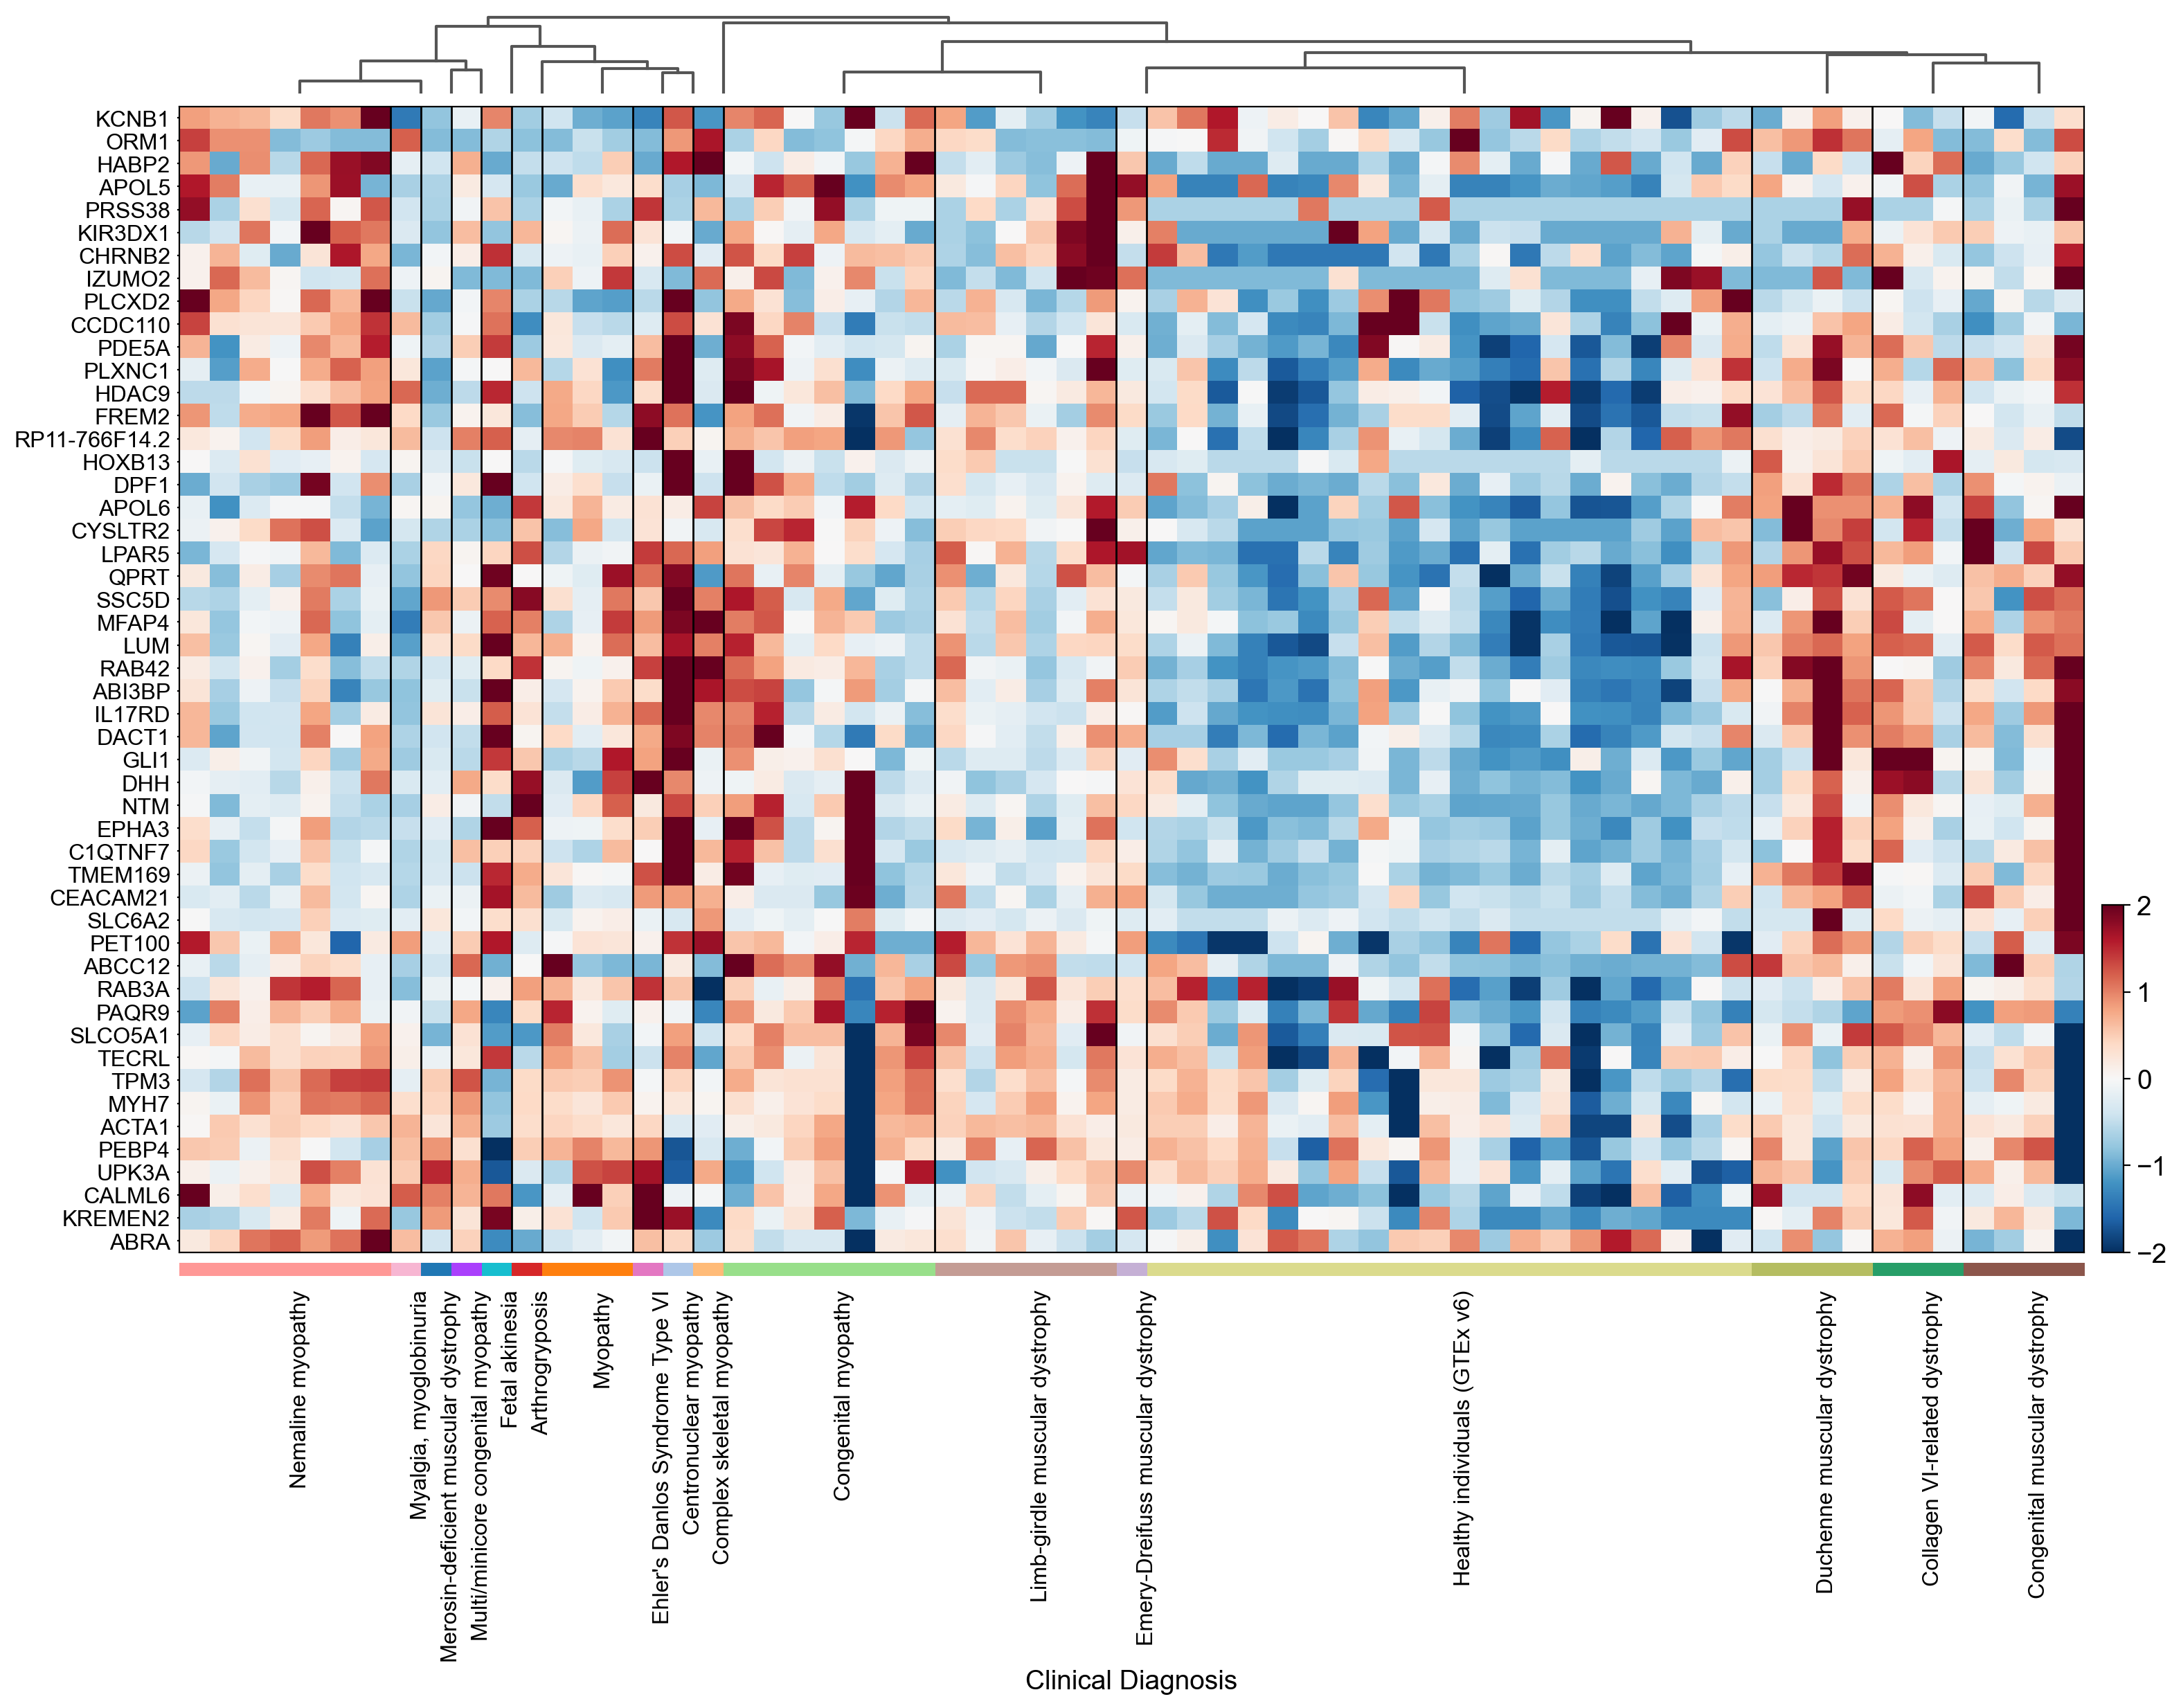

In [79]:
ggg = de.sort_values('scores').names.unique()[:50]
idx = sort_by_correlation(muscle[:, ggg].X.toarray(), rows=False, method='average')
ggg = ggg[idx]

sc.pl.heatmap(muscle, ggg, 'Clinical Diagnosis', vmin=-2, vmax=2, cmap='RdBu_r', figsize=(18,12), dendrogram=True, swap_axes=True, show_gene_labels=True)